In [79]:
# Import Library
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Load the dataset
file_path = "trimed_hourly_data.csv"
df = pd.read_csv(file_path)
df

,Unnamed: 0,Date-Hours,M7,E98,M182
0,15,04/08/2561 6.00,1095,799,29.4
1,16,04/08/2561 9.00,1095,799,30
2,17,04/08/2561 12.00,1095,799,31.6
3,18,04/08/2561 15.00,1090,801.7,32.8
4,19,04/08/2561 18.00,1095,801.7,34.4
...,...,...,...,...,...
11485,11500,19/11/2567 6.00,257,121.1,197.8
11486,11501,19/11/2567 9.00,260.5,121.1,192.7
11487,11502,19/11/2567 12.00,264,121.1,187.6
11488,11503,19/11/2567 15.00,267.5,121.1,180.8


In [80]:
# Drop unused columns
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('Date-Hours', axis=1)
df['M7'] = pd.to_numeric(df['M7'], errors='coerce')
df = df.dropna(subset=['M7'])
df['M182'] = pd.to_numeric(df['M182'], errors='coerce')
df = df.dropna(subset=['M182'])
df['E98'] = pd.to_numeric(df['E98'], errors='coerce')
df = df.dropna(subset=['E98'])

df

,M7,E98,M182
0,1095.0,799.0,29.4
1,1095.0,799.0,30.0
2,1095.0,799.0,31.6
3,1090.0,801.7,32.8
4,1095.0,801.7,34.4
...,...,...,...
11485,257.0,121.1,197.8
11486,260.5,121.1,192.7
11487,264.0,121.1,187.6
11488,267.5,121.1,180.8


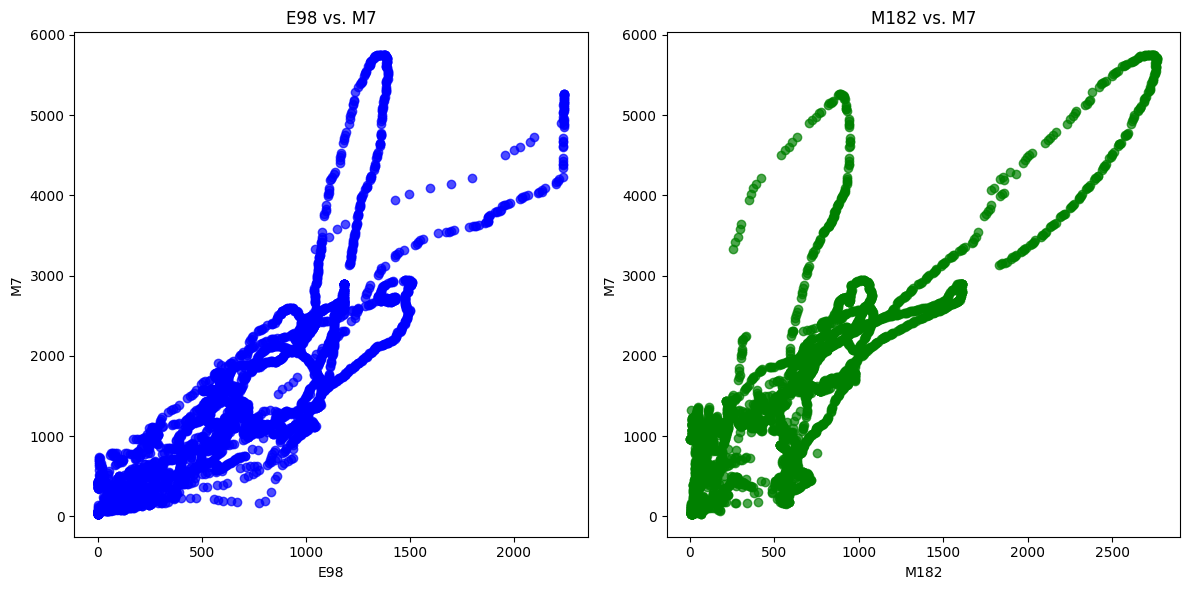

In [81]:
# Instance features and target variable
X = df[['E98', 'M182']]
y = df[['M7']]

# Plot E98 vs. M7
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, first plot)
plt.scatter(df['E98'], df['M7'], color='blue', alpha=0.7)
plt.title('E98 vs. M7')
plt.xlabel('E98')
plt.ylabel('M7')

# Plot M182 vs. M7
plt.subplot(1, 2, 2)  # Second plot
plt.scatter(df['M182'], df['M7'], color='green', alpha=0.7)
plt.title('M182 vs. M7')
plt.xlabel('M182')
plt.ylabel('M7')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


Correlation Matrix:
E98     0.868164
M182    0.873718
M7      1.000000
Name: M7, dtype: float64
Unfiltered data shape: (4214, 2), (4214, 1)
Filtered data shape: (3996, 2), (3996, 1)


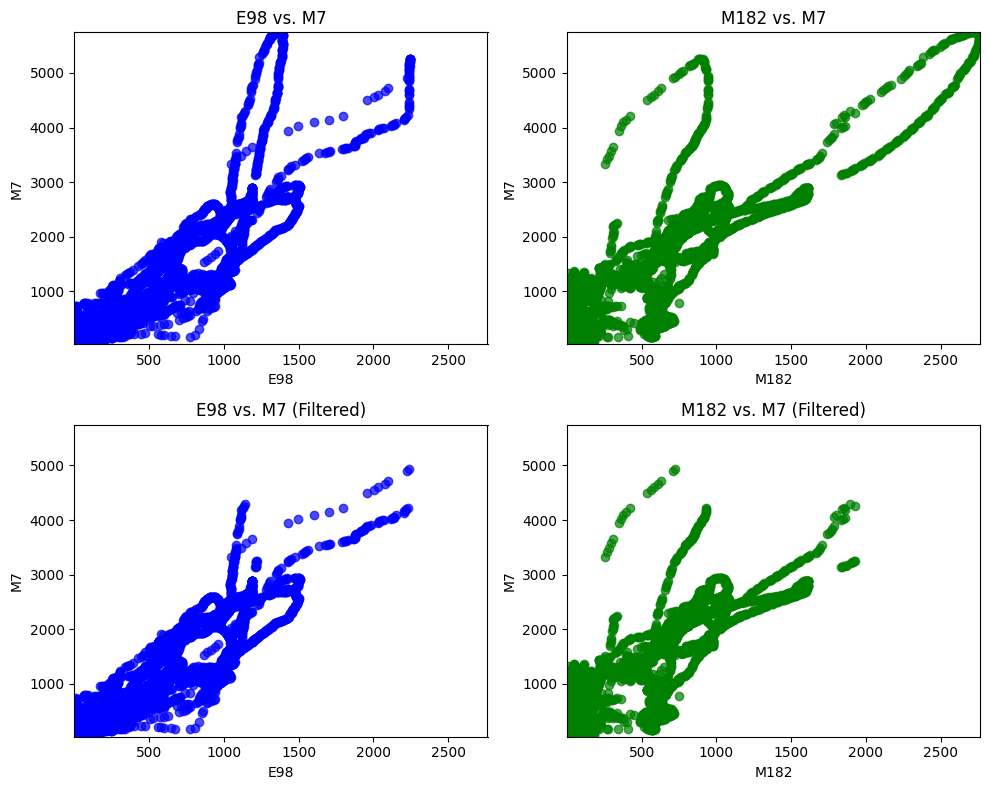

In [82]:
# Compute the correlation matrix
print("Correlation Matrix:")
correlation_matrix = pd.concat([X, y], axis=1).corr()
print(correlation_matrix['M7'])

# Remove outliers using IQR method
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
outlier_mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
X_filtered = X[outlier_mask]
y_filtered = y.loc[outlier_mask]

# Convert y and y_filtered to Series for min/max calculations
y_series = y.iloc[:, 0]
y_filtered_series = y_filtered.iloc[:, 0]

print(f"Unfiltered data shape: {X.shape}, {y.shape}")
print(f"Filtered data shape: {X_filtered.shape}, {y_filtered.shape}")

# Define consistent limits
x_limit = [min(X['E98'].min(), X['M182'].min()), max(X['E98'].max(), X['M182'].max())]
y_limit = [min(y_series.min(), y_filtered_series.min()), max(y_series.max(), y_filtered_series.max())]

plt.figure(figsize=(10, 8))

# First subplot
plt.subplot(2, 2, 1)
plt.scatter(X['E98'], y_series, color='blue', alpha=0.7)
plt.title('E98 vs. M7')
plt.xlabel('E98')
plt.ylabel('M7')
plt.xlim(x_limit)
plt.ylim(y_limit)

# Second subplot
plt.subplot(2, 2, 2)
plt.scatter(X['M182'], y_series, color='green', alpha=0.7)
plt.title('M182 vs. M7')
plt.xlabel('M182')
plt.ylabel('M7')
plt.xlim(x_limit)
plt.ylim(y_limit)

# Third subplot
plt.subplot(2, 2, 3)
plt.scatter(X_filtered['E98'], y_filtered_series, color='blue', alpha=0.7)
plt.title('E98 vs. M7 (Filtered)')
plt.xlabel('E98')
plt.ylabel('M7')
plt.xlim(x_limit)
plt.ylim(y_limit)

# Fourth subplot
plt.subplot(2, 2, 4)
plt.scatter(X_filtered['M182'], y_filtered_series, color='green', alpha=0.7)
plt.title('M182 vs. M7 (Filtered)')
plt.xlabel('M182')
plt.ylabel('M7')
plt.xlim(x_limit)
plt.ylim(y_limit)

# Adjust layout
plt.tight_layout()
plt.show()


In [83]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42
)

print(f"Train/Test split: {X_train.shape}, {X_test.shape}")

# Initialize models and feature sets
models = {
    'Random Forest': RandomForestRegressor(random_state=42)
}

feature_sets = {
    'All Features': X_train.columns,
    'Top 5 Features': X_train.columns[:5]
}

# Scale the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), columns=X_test.columns, index=X_test.index
)

# Step 5: Evaluate models and feature sets using cross-validation
best_score = float('inf')
best_model_name = None
best_features_name = None
best_model_instance = None
best_features = None

for model_name, model in models.items():
    for feature_set_name, features in feature_sets.items():
        X_train_subset = X_train_scaled[features]
        scores = cross_val_score(
            model, X_train_subset, y_train, cv=5, scoring='neg_mean_squared_error'
        )
        avg_score = -scores.mean()
        
        print(f"{model_name} with {feature_set_name}: MSE = {avg_score:.2f}")
        
        if avg_score < best_score:
            best_score = avg_score
            best_model_name = model_name
            best_features_name = feature_set_name
            best_model_instance = model
            best_features = features

# Step 6: Train the best model on the best feature set
print(f"Best Model: {best_model_name} with {best_features_name} (MSE: {best_score:.2f})")
best_model_instance.fit(X_train_scaled[best_features], y_train)
y_pred = best_model_instance.predict(X_test_scaled[best_features])

# Step 7: Evaluate the final model on the test set
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {test_mse:.2f}")
print(f"Test R-squared: {test_r2:.2f}")

Train/Test split: (3196, 2), (800, 2)


/Users/worayot/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/worayot/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/worayot/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/worayot/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array

Random Forest with All Features: MSE = 23706.58


/Users/worayot/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/worayot/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/worayot/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/worayot/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array

Random Forest with Top 5 Features: MSE = 23706.58
Best Model: Random Forest with All Features (MSE: 23706.58)


/Users/worayot/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test MSE: 16594.24
Test R-squared: 0.98


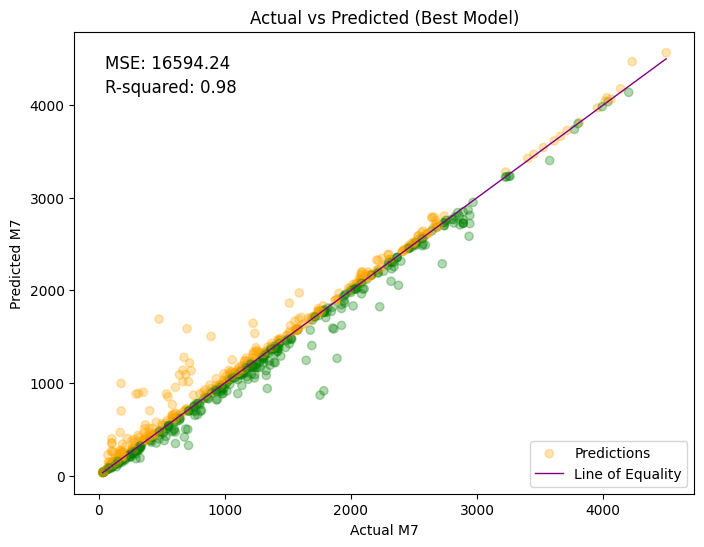

In [84]:
# Ensure y_test and y_pred are 1D arrays
y_test_array = y_test.squeeze()
y_pred_array = y_pred.squeeze()

# Generate colors: one for y_test, one for y_pred
colors = np.where(y_test_array > y_pred_array, 'green', 'orange')  # Green if under-predicted, orange otherwise

plt.figure(figsize=(8, 6))

# Scatter plot with custom colors
plt.scatter(y_test_array, y_pred_array, color=colors, alpha=0.3, label='Predictions')

# Line of equality
plt.plot(
    [y_test_array.min(), y_test_array.max()],
    [y_test_array.min(), y_test_array.max()],
    color='purple',
    linewidth=1,
    label='Line of Equality'
)

# Add title and labels
plt.title('Actual vs Predicted (Best Model)')
plt.xlabel('Actual M7')
plt.ylabel('Predicted M7')

# Add performance metrics
plt.text(0.05, 0.95, f"MSE: {test_mse:.2f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f"R-squared: {test_r2:.2f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Add legend and show the plot
plt.legend()
plt.show()


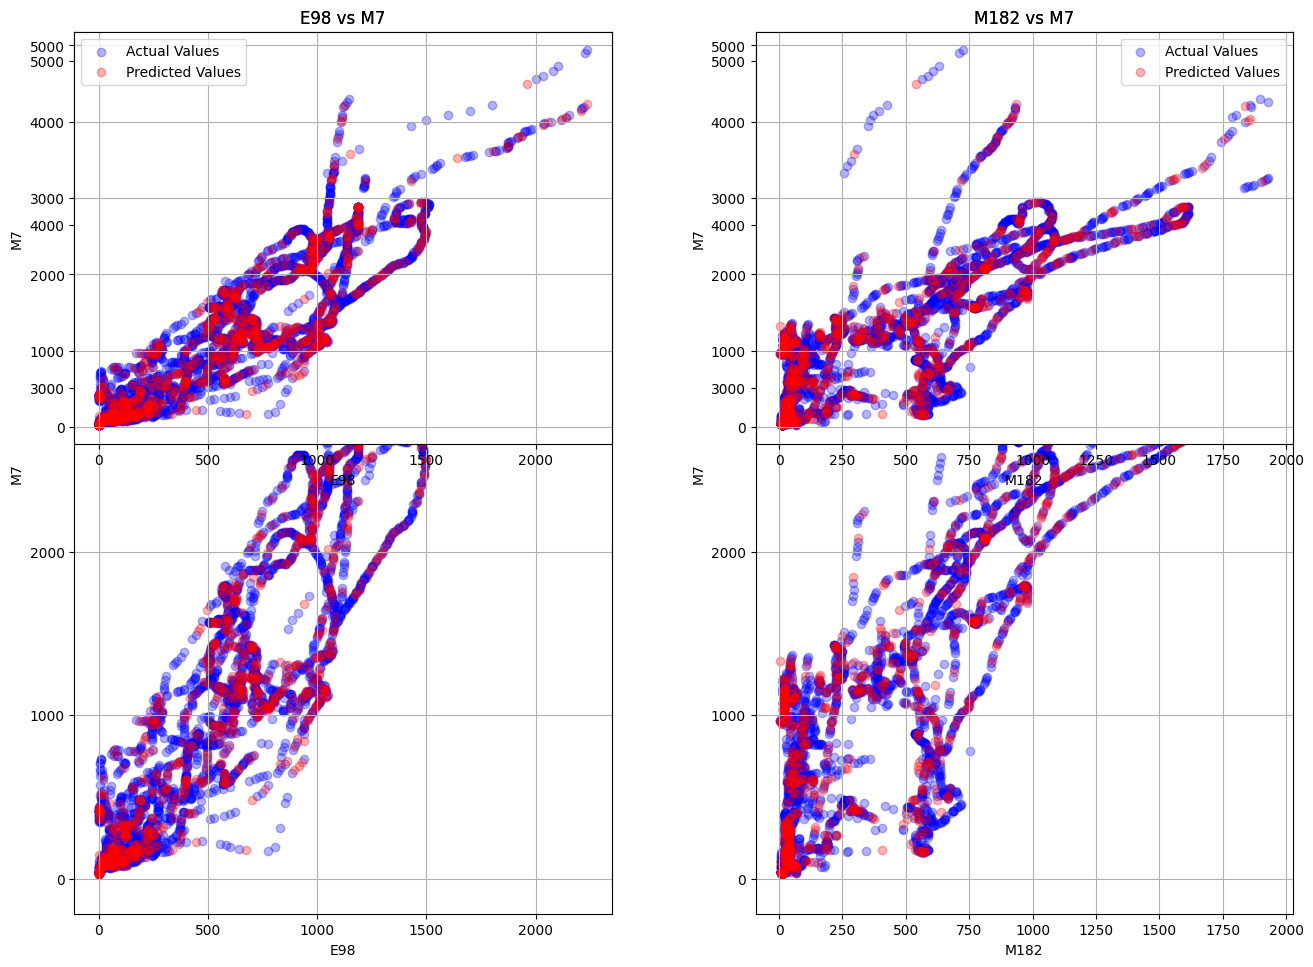

In [85]:
# Scatter plot for E98 vs. M7 for visualization
plt.figure(figsize=(14, 10))

# Plot actual vs predicted values of E98 vs. M7
plt.subplot(1, 2, 1)
plt.scatter(X_train['E98'], y_train, color='blue', label='Actual Values', alpha=0.3)
plt.scatter(X_test['E98'], y_test, color='red', label='Predicted Values', alpha=0.3)
plt.title('E98 vs M7')
plt.xlabel('E98')
plt.ylabel('M7')
plt.legend()
plt.grid()

# Plot actual vs predicted values of M182 vs. M7
plt.subplot(1, 2, 2)
plt.scatter(X_train['M182'], y_train, color='blue', label='Actual Values', alpha=0.3)
plt.scatter(X_test['M182'], y_test, color='red', label='Predicted Values', alpha=0.3)
plt.title('M182 vs M7')
plt.xlabel('M182')
plt.ylabel('M7')
plt.legend()
plt.grid()

# Plot actual vs predicted values of E98 vs. M7
plt.subplot(2, 2, 1)
plt.scatter(X_train['E98'], y_train, color='blue', label='Actual Values', alpha=0.3)
plt.scatter(X_test['E98'], y_test, color='red', label='Predicted Values', alpha=0.3)
plt.title('E98 vs M7')
plt.xlabel('E98')
plt.ylabel('M7')
plt.legend()
plt.grid()

# Plot actual vs predicted values of M182 vs. M7
plt.subplot(2, 2, 2)
plt.scatter(X_train['M182'], y_train, color='blue', label='Actual Values', alpha=0.3)
plt.scatter(X_test['M182'], y_test, color='red', label='Predicted Values', alpha=0.3)
plt.title('M182 vs M7')
plt.xlabel('M182')
plt.ylabel('M7')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()

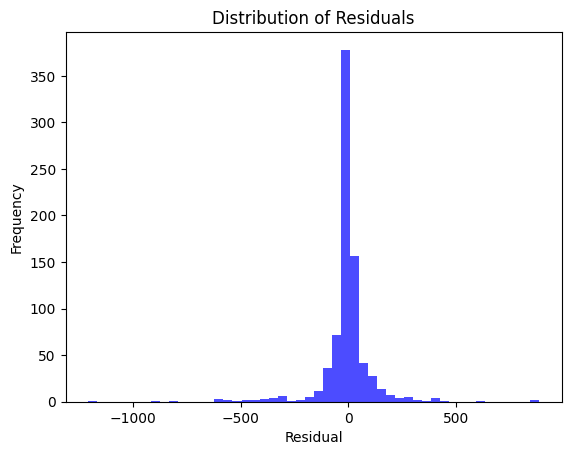

In [86]:
# Ensure compatibility of shapes
residuals = np.array(y_test).ravel() - np.array(y_pred).ravel()

# Plot the distribution of residuals
plt.hist(residuals, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()